# libraries

In [2]:
import cometspy as c
import os
import pandas as pd
import matplotlib.pyplot as plt
import cobra
import time, random

In [3]:
import numpy as np

In [3]:
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)
print("Cobra version:", cobra.__version__)

Pandas version: 2.0.0
NumPy version: 1.26.4
Cobra version: 0.29.1


# data - models and diet

## diet

In [4]:
#diet
diet = pd.read_csv('Magnusdottir_2017_TableS12_diets.csv')
diet.head()

,metabolite_ID,Exchange_reaction,metabolite_name,western,high_fiber
0,arab_L,EX_arab_L(e),L-arabinose,0.178783,0.047368
1,cellb,EX_cellb(e),Cellobiose,0.074493,0.019737
2,drib,EX_drib(e),2-deoxy-D-ribose,0.178783,0.047368
3,fru,EX_fru(e),D-Fructose,0.148986,0.039474
4,fuc_L,EX_fuc_L(e),L-fucose,0.148986,0.039474


In [5]:
diet_dict = dict(zip(diet['metabolite_ID'], diet['western'])) #initial diet dictionary

In [20]:
lis = diet['Exchange_reaction']
#print(lis)
if any(item.strip() == 'EX_o2(e)' for item in lis):
    print('yes')


## models

In [6]:
# model dict to store the models

models_dir = "models20"
model_files = sorted(os.listdir(models_dir))

models_meta = {} # id: name
models = {} # id: model
#comets_models = {} # id: comets model

for i in range(20): #change range according to the number of models
    model_name = model_files[i].split(".")[0]
    model_path = os.path.join(models_dir, model_files[i])
    models_meta[i+1] = model_name #update metadata
    print('loading model', i+1,'of 20 models...')

    model = cobra.io.read_sbml_model(model_path) 
    models[i+1] = model #update models dict
    #comets_model = c.model(model)

print('Done loading the models!')

loading model 1 of 20 models...
loading model 2 of 20 models...
loading model 3 of 20 models...
loading model 4 of 20 models...
loading model 5 of 20 models...
loading model 6 of 20 models...
loading model 7 of 20 models...
loading model 8 of 20 models...
loading model 9 of 20 models...
loading model 10 of 20 models...
loading model 11 of 20 models...
loading model 12 of 20 models...
loading model 13 of 20 models...
loading model 14 of 20 models...
loading model 15 of 20 models...
loading model 16 of 20 models...
loading model 17 of 20 models...
loading model 18 of 20 models...
loading model 19 of 20 models...
loading model 20 of 20 models...
Done loading the models!


# preprocessing steps for models

# monocultures

In [8]:
#parameters - chemostat condition
#part1

mono_params = c.params()

mono_params.set_param("spaceWidth", 0.1)
mono_params.set_param("defaultVmax", 20.) #vmax = 20 mmol gDW-1h-1 for all metabolites
mono_params.set_param("defaultKm", 0.05) #km = 0.05 mmol

mono_params.set_param('timeStep', 0.1) #hours - The amount of time between two consecutive simulation updates
mono_params.set_param('maxSpaceBiomass', 10.) #gDW
mono_params.set_param('maxCycles', 300) #duration of simulation in timesteps - number of simulation cycles #30 hours

#save media and flux data
mono_params.set_param('writeFluxLog', False)
mono_params.set_param('writeMediaLog', False)
mono_params.set_param('FluxLogRate', 1)
mono_params.set_param('MediaLogRate', 1)
#mono_params.set_param('writeBiomassLog', True) 
mono_params.set_param('writeTotalBiomassLog', True) #save to output if True
mono_params.show_params()


,VALUE,UNITS
BiomassLogName,biomass,
BiomassLogRate,1,cycles
FluxLogName,flux_out,
FluxLogRate,1,cycles
MediaLogName,media_out,
...,...,...
writeBiomassLog,False,logical
writeFluxLog,False,logical
writeMediaLog,False,logical
writeSpecificMediaLog,False,logical


In [ ]:
initial_pop = 0.01 #initial population of the model
dilution_rate = 0.1 # /hr
biomass_dict = {} #initialize biomass dict for storing timeseries biomass data - id:timeseries biomass data
#media_dict = {} #initialize media dict for storing timeseries media data - id:timeseries media data
biomass_df = pd.DataFrame() #initialize dataframe to store biomass data
#media_df = pd.DataFrame() #initialize dataframe to store media data

#parameters update part2
mono_params.set_param('deathRate', dilution_rate)
mono_params.set_param('metaboliteDilutionRate', dilution_rate)

#time watch
start_time = time.time()

# create layout and run monoculture simulations
for i in range(20):
    model = models[i+1]
    #make comets model
    comets_model = c.model(model)
    #set model id
    comets_model.id = 'model' + str(i+1)
    #set initial population and open exchanges
    comets_model.initial_pop = [0,0,initial_pop] # x, y, gDW
    comets_model.open_exchanges()

    #create layout
    print('Constructing layout for model', i+1, '...')
    mono_layout = c.layout(comets_model)
    #print(mono_layout.get_model_ids())

    ## NOTE: cobrapy media are set using exchange reaction IDs, whereas COMETS media are set using metabolite ids

    #set diet
    for met in diet_dict:
        metabolite = (met+'[e]')
        conc = diet_dict[met]
        #print(metabolite, conc)
        if metabolite in mono_layout.media['metabolite'].values:
            mono_layout.set_specific_metabolite(metabolite, conc) #todo: find a way to suppress warnings

    #set media refresh rate - chemostat conditions
    for met in mono_layout.media['metabolite']:
        initconc = mono_layout.media[mono_layout.media['metabolite'] == met]['init_amount'].values[0]
        refreshrate = initconc*dilution_rate
        mono_layout.set_specific_refresh(met, refreshrate)

    simulation = c.comets(mono_layout, mono_params)
    simulation.run()

    #save biomass data
    biomass_dict[i+1] = simulation.total_biomass
    #media_dict[i] = simulation.get_metabolite_time_series()
    
    #save cycle indices to dataframe
    if i == 0:
        biomass_df['cycle'] = biomass_dict[i+1]['cycle']
        #media_df['cycle'] = simulation.get_cycle_indices()

    #save biomass data to dataframe
    biomass_df['model'+str(i+1)] = biomass_dict[i+1][f'model{i+1}']

    print('model', i+1, 'done!')
    print('\n\n ************************************ \n\n')
    time.sleep(2) #sleep for 5 seconds to avoid overloading the server

end_time = time.time()
print('Monoculture simulations done!')
print('Time taken:', end_time-start_time, 'seconds')

In [13]:
biomass_df.head()

,cycle,model1,model2,model3,model4,model5,model6,model7,model8,model9,...,model11,model12,model13,model14,model15,model16,model17,model18,model19,model20
0,0,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
1,1,0.020575,0.039824,0.027137,0.009900,0.030972,0.026983,0.046556,0.009900,0.050672,...,0.009900,0.009900,0.050924,0.009900,0.026983,0.016944,0.027137,0.009900,0.041828,0.009900
2,2,0.042330,0.141260,0.073640,0.009801,0.088784,0.072810,0.197220,0.009801,0.222699,...,0.009801,0.009801,0.214407,0.009801,0.072810,0.028708,0.073640,0.009801,0.163527,0.009801
3,3,0.071482,0.303650,0.153892,0.009703,0.152350,0.108044,0.434087,0.009703,0.523097,...,0.009703,0.009703,0.427891,0.009703,0.196463,0.042667,0.170708,0.009703,0.365872,0.009703
4,4,0.094051,0.419813,0.228999,0.009606,0.208726,0.121386,0.692082,0.009606,0.788879,...,0.009606,0.009606,0.628601,0.009606,0.255613,0.054276,0.241245,0.009606,0.467242,0.009606


In [14]:
biomass_df.to_csv('biomass_data_20spmonoculture_30hrs.csv', index=False)

# plotting - monoculture rates

In [16]:
biomass_df = pd.DataFrame(biomass_dict[0]['cycle'])
for i in biomass_dict:
    biomass_df[f'model{i}'] = biomass_dict[i][f'model{i}']
biomass_df

,cycle,model0,model1,model2,model3
0,0,0.010000,0.010000,0.010000,0.010000
1,1,0.020575,0.039824,0.027137,0.009900
2,2,0.042330,0.141260,0.073640,0.009801
3,3,0.071482,0.303650,0.153892,0.009703
4,4,0.094051,0.419813,0.228999,0.009606
...,...,...,...,...,...
296,296,0.196617,0.418229,0.382563,0.000511
297,297,0.196633,0.418226,0.382584,0.000505
298,298,0.196649,0.418224,0.382606,0.000500
299,299,0.196664,0.418221,0.382627,0.000495


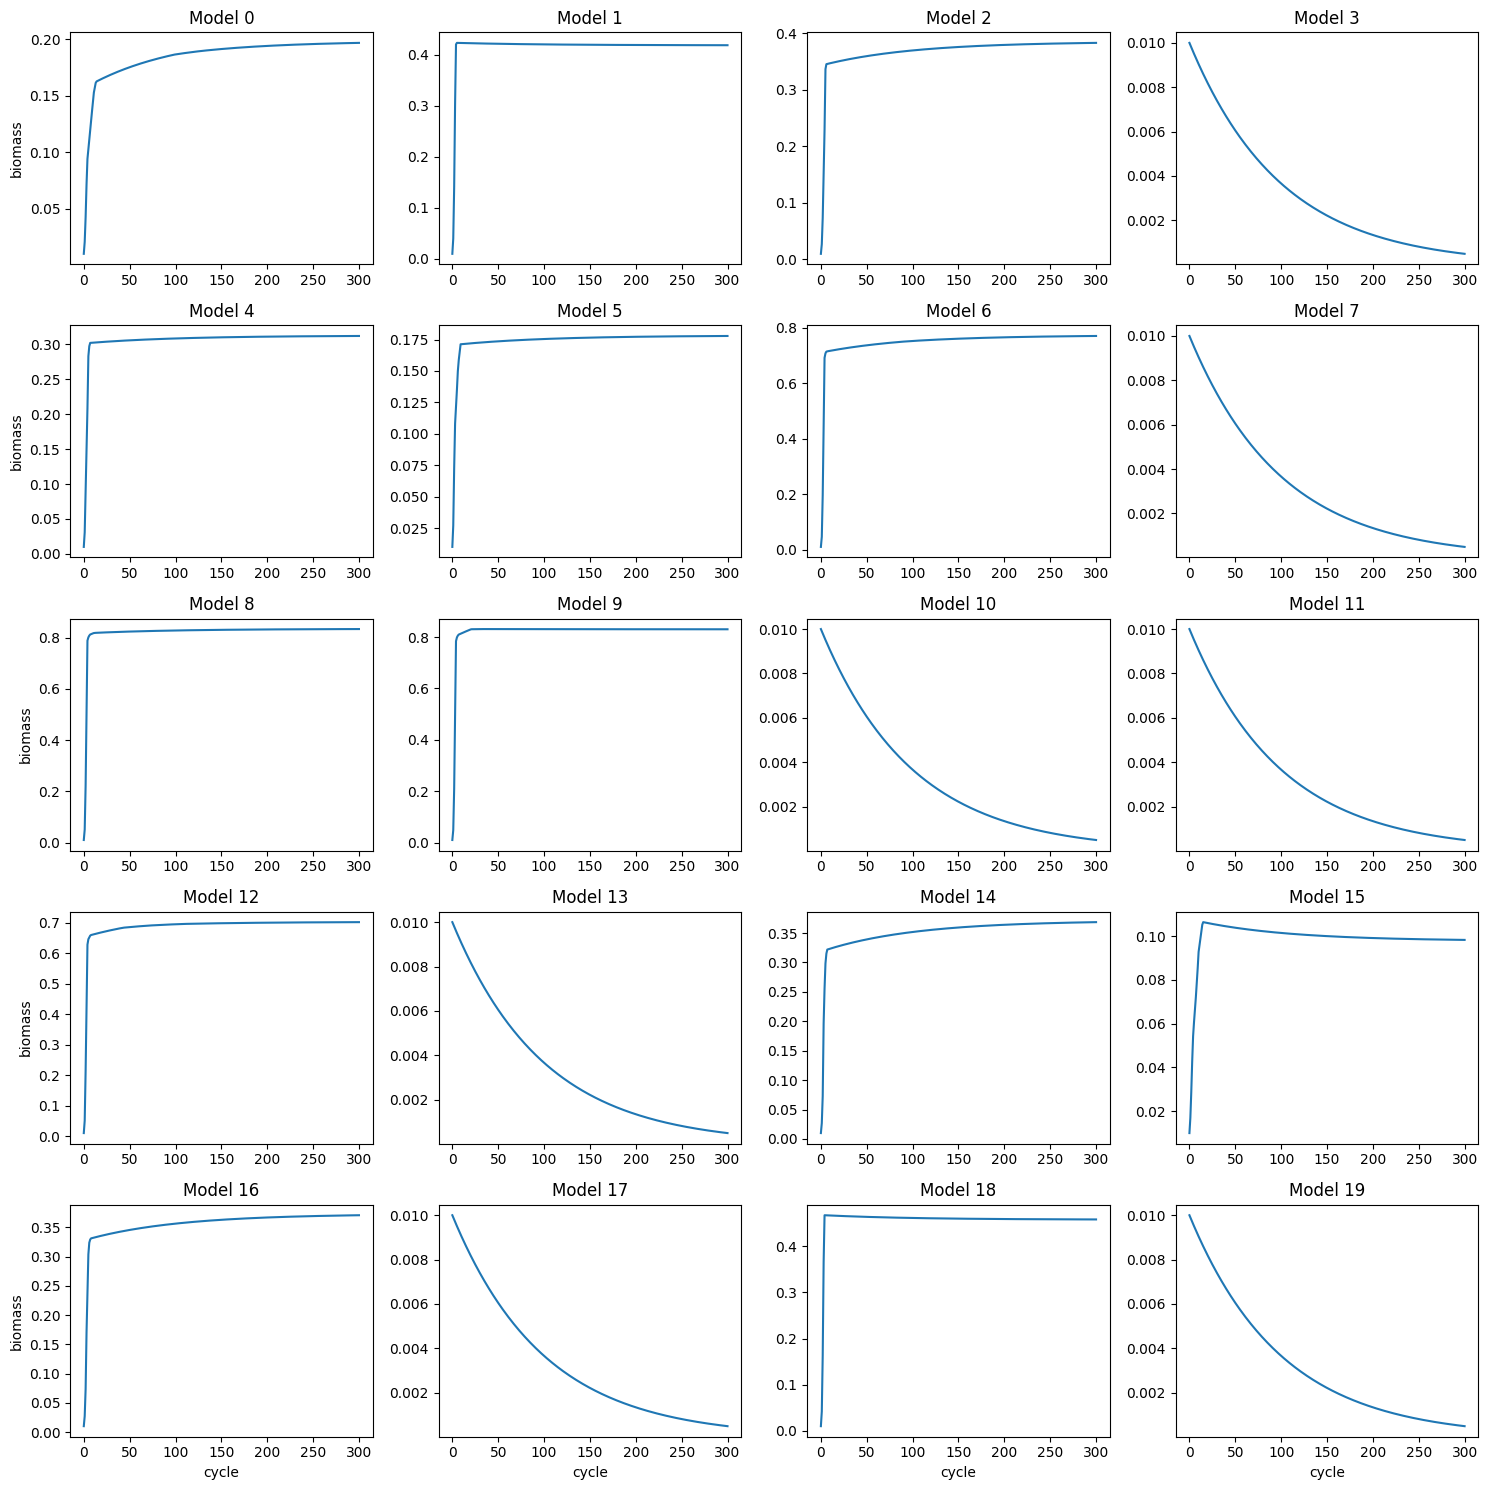

In [68]:
import matplotlib.pyplot as plt

# Create a figure and axes for subplots
fig, axs = plt.subplots(5, 4, figsize=(15, 15))#, hspace=0.5)

# Flatten the axes array for easy indexing
axs = axs.flatten()

# Iterate over the models and plot the dataframes
for i in range(20):
    # Get the dataframe for the current model
    df = biomass_dict[i]
    
    # Plot the dataframe on the corresponding subplot
    axs[i].plot(df['cycle'], df[f"model{i}"])
    axs[i].set_title(f"Model {i}")
    if i >= 16:
        axs[i].set_xlabel("cycle")

    if i % 4 == 0:
        axs[i].set_ylabel("biomass")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


# pairwise

In [24]:
from itertools import combinations
pairwise_numbers = list(combinations(range(1, 21), 2))
len(pairwise_numbers)

190

In [25]:
models

{1: <Model M_Actinomyces_odontolyticus_ATCC_17982__44____32__AGORA__32__version__32__1__46__03 at 0x1a08dbac950>,
 2: <Model M_Bacteroides_eggerthii_DSM_20697__44____32__AGORA__32__version__32__1__46__03 at 0x1a0b78b8200>,
 3: <Model M_Bacteroides_ovatus_ATCC_8483__44____32__AGORA__32__version__32__1__46__03 at 0x1a0b8170320>,
 4: <Model M_Bacteroides_thetaiotaomicron_VPI_5482__44____32__AGORA__32__version__32__1__46__03 at 0x1a0bacfc650>,
 5: <Model M_Bifidobacterium_longum_infantis_ATCC_15697__44____32__AGORA__32__version__32__1__46__03 at 0x1a0bb61c950>,
 6: <Model M_Butyrivibrio_fibrisolvens_16_4__44____32__AGORA__32__version__32__1__46__03 at 0x1a0bbf94650>,
 7: <Model M_Citrobacter_freundii_UCI_31__44____32__AGORA__32__version__32__1__46__03 at 0x1a0bc9f4590>,
 8: <Model M_Clostridium_butyricum_DSM_10702__44____32__AGORA__32__version__32__1__46__03 at 0x1a0bbfc7980>,
 9: <Model M_Escherichia_coli_O157_H7_str_Sakai__44____32__AGORA__32__version__32__1__46__03 at 0x1a0c0ccc170>,
 1

In [29]:
#params

pairwise_params = c.params()
pairwise_params = c.params()
pairwise_params.set_param('deathRate', dilution_rate)
pairwise_params.set_param('metaboliteDilutionRate', dilution_rate)

pairwise_params.set_param("spaceWidth", 0.1)
pairwise_params.set_param("defaultVmax", 20.) #vmax = 20 mmol gDW-1h-1 for all metabolites
pairwise_params.set_param("defaultKm", 0.05) #km = 0.05 mmol

pairwise_params.set_param('timeStep', 0.1) #hours - The amount of time between two consecutive simulation updates
pairwise_params.set_param('maxSpaceBiomass', 10.) #gDW
pairwise_params.set_param('maxCycles', 300) #duration of simulation in timesteps - number of simulation cycles

#save media and flux data
pairwise_params.set_param('writeFluxLog', False)
pairwise_params.set_param('writeMediaLog', False)
#pairwise_params.set_param('FluxLogRate', 1)
#pairwise_params.set_param('MediaLogRate', 1)


In [43]:
import warnings
# Suppress the specific warning
warnings.filterwarnings("ignore", category=FutureWarning)


# Reset the warning filter
#warnings.resetwarnings()

In [47]:
initial_pop = 0.01 #initial population of the model
dilution_rate = 0.1 # /hr
counter = 1
pairwise_biomassdict = {} #initialize biomass dict for storing timeseries biomass data - id:timeseries biomass data
totbiomass_df = pd.DataFrame()

for pair in pairwise_numbers:
    model1 = 0
    model2 = 0
    a, b = pair
    model1 = models[a]  # model 1
    model2 = models[b]  # model 2

    comets_model1 = c.model(model1)
    comets_model2 = c.model(model2)

    comets_model1.id = 'model' + str(a)
    comets_model2.id = 'model' + str(b)

    comets_model1.initial_pop = [0, 0, initial_pop]  # x, y, gDW
    comets_model2.initial_pop = [0, 0, initial_pop]  # x, y, gDW   

    comets_model1.open_exchanges()
    comets_model2.open_exchanges()

    #create layout
    print(counter, 'of 190:', 'Constructing layout for model', a, 'and model', b, '...')
    layout = c.layout([comets_model1, comets_model2])

    #set diet
    for met in diet_dict:
        metabolite = (met + '[e]')
        conc = diet_dict[met]
        # print(metabolite, conc)
        if metabolite in layout.media['metabolite'].values:
            layout.set_specific_metabolite(metabolite, conc) 
    
    #set media refresh rate - chemostat conditions
    for met in layout.media['metabolite']:
        initconc = layout.media[layout.media['metabolite'] == met]['init_amount'].values[0]
        refreshrate = initconc * dilution_rate
        layout.set_specific_refresh(met, refreshrate)
    

    pairwise_simulation = c.comets(layout, pairwise_params)
    pairwise_simulation.run()

    pairwise_biomassdict[f'{counter}_model_{a}_{b}'] = pairwise_simulation.total_biomass

    #save biomass data
    if counter == 1:
        totbiomass_df['cycle'] = pairwise_simulation.total_biomass['cycle']
    
    totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
    totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']         

    counter += 1 
    print('pairwise', a, b, 'done!')

1 of 190: Constructing layout for model 1 and model 2 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 1 2 done!
2 of 190: Constructing layout for model 1 and model 3 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 1 3 done!
3 of 190: Constructing layout for model 1 and model 4 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 1 4 done!
4 of 190: Constructing layout for model 1 and model 5 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 1 5 done!
5 of 190: Constructing layout for model 1 and model 6 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 1 6 done!
6 of 190: Constructing layout for model 1 and model 7 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 1 7 done!
7 of 190: Constructing layout for model 1 and model 8 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 1 8 done!
8 of 190: Constructing layout for model 1 and model 9 ...

Running COMETS simulation ...



C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


51 of 190: Constructing layout for model 3 and model 17 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 3 17 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


52 of 190: Constructing layout for model 3 and model 18 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 3 18 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


53 of 190: Constructing layout for model 3 and model 19 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 3 19 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


54 of 190: Constructing layout for model 3 and model 20 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 3 20 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


55 of 190: Constructing layout for model 4 and model 5 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 4 5 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


56 of 190: Constructing layout for model 4 and model 6 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 4 6 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


57 of 190: Constructing layout for model 4 and model 7 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 4 7 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


58 of 190: Constructing layout for model 4 and model 8 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 4 8 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


59 of 190: Constructing layout for model 4 and model 9 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 4 9 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


60 of 190: Constructing layout for model 4 and model 10 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 4 10 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


61 of 190: Constructing layout for model 4 and model 11 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 4 11 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


62 of 190: Constructing layout for model 4 and model 12 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 4 12 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


63 of 190: Constructing layout for model 4 and model 13 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 4 13 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


64 of 190: Constructing layout for model 4 and model 14 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 4 14 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


65 of 190: Constructing layout for model 4 and model 15 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 4 15 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


66 of 190: Constructing layout for model 4 and model 16 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 4 16 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


67 of 190: Constructing layout for model 4 and model 17 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 4 17 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


68 of 190: Constructing layout for model 4 and model 18 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 4 18 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


69 of 190: Constructing layout for model 4 and model 19 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 4 19 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


70 of 190: Constructing layout for model 4 and model 20 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 4 20 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


71 of 190: Constructing layout for model 5 and model 6 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 5 6 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


72 of 190: Constructing layout for model 5 and model 7 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 5 7 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


73 of 190: Constructing layout for model 5 and model 8 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 5 8 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


74 of 190: Constructing layout for model 5 and model 9 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 5 9 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


75 of 190: Constructing layout for model 5 and model 10 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 5 10 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


76 of 190: Constructing layout for model 5 and model 11 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 5 11 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


77 of 190: Constructing layout for model 5 and model 12 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 5 12 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


78 of 190: Constructing layout for model 5 and model 13 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 5 13 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


79 of 190: Constructing layout for model 5 and model 14 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 5 14 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


80 of 190: Constructing layout for model 5 and model 15 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 5 15 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


81 of 190: Constructing layout for model 5 and model 16 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 5 16 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


82 of 190: Constructing layout for model 5 and model 17 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 5 17 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


83 of 190: Constructing layout for model 5 and model 18 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 5 18 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


84 of 190: Constructing layout for model 5 and model 19 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 5 19 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


85 of 190: Constructing layout for model 5 and model 20 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 5 20 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


86 of 190: Constructing layout for model 6 and model 7 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 6 7 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


87 of 190: Constructing layout for model 6 and model 8 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 6 8 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


88 of 190: Constructing layout for model 6 and model 9 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 6 9 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


89 of 190: Constructing layout for model 6 and model 10 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 6 10 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


90 of 190: Constructing layout for model 6 and model 11 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 6 11 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


91 of 190: Constructing layout for model 6 and model 12 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 6 12 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


92 of 190: Constructing layout for model 6 and model 13 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 6 13 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


93 of 190: Constructing layout for model 6 and model 14 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 6 14 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


94 of 190: Constructing layout for model 6 and model 15 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 6 15 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


95 of 190: Constructing layout for model 6 and model 16 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 6 16 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


96 of 190: Constructing layout for model 6 and model 17 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 6 17 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


97 of 190: Constructing layout for model 6 and model 18 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 6 18 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


98 of 190: Constructing layout for model 6 and model 19 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 6 19 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


99 of 190: Constructing layout for model 6 and model 20 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 6 20 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


100 of 190: Constructing layout for model 7 and model 8 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 7 8 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


101 of 190: Constructing layout for model 7 and model 9 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 7 9 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


102 of 190: Constructing layout for model 7 and model 10 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 7 10 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


103 of 190: Constructing layout for model 7 and model 11 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 7 11 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


104 of 190: Constructing layout for model 7 and model 12 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 7 12 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


105 of 190: Constructing layout for model 7 and model 13 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 7 13 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


106 of 190: Constructing layout for model 7 and model 14 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 7 14 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


107 of 190: Constructing layout for model 7 and model 15 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 7 15 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


108 of 190: Constructing layout for model 7 and model 16 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 7 16 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


109 of 190: Constructing layout for model 7 and model 17 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 7 17 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


110 of 190: Constructing layout for model 7 and model 18 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 7 18 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


111 of 190: Constructing layout for model 7 and model 19 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 7 19 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


112 of 190: Constructing layout for model 7 and model 20 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 7 20 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


113 of 190: Constructing layout for model 8 and model 9 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 8 9 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


114 of 190: Constructing layout for model 8 and model 10 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 8 10 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


115 of 190: Constructing layout for model 8 and model 11 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 8 11 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


116 of 190: Constructing layout for model 8 and model 12 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 8 12 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


117 of 190: Constructing layout for model 8 and model 13 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 8 13 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


118 of 190: Constructing layout for model 8 and model 14 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 8 14 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


119 of 190: Constructing layout for model 8 and model 15 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 8 15 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


120 of 190: Constructing layout for model 8 and model 16 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 8 16 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


121 of 190: Constructing layout for model 8 and model 17 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 8 17 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


122 of 190: Constructing layout for model 8 and model 18 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 8 18 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


123 of 190: Constructing layout for model 8 and model 19 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 8 19 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


124 of 190: Constructing layout for model 8 and model 20 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 8 20 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


125 of 190: Constructing layout for model 9 and model 10 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 9 10 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


126 of 190: Constructing layout for model 9 and model 11 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 9 11 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


127 of 190: Constructing layout for model 9 and model 12 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 9 12 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


128 of 190: Constructing layout for model 9 and model 13 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 9 13 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


129 of 190: Constructing layout for model 9 and model 14 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 9 14 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


130 of 190: Constructing layout for model 9 and model 15 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 9 15 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


131 of 190: Constructing layout for model 9 and model 16 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 9 16 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


132 of 190: Constructing layout for model 9 and model 17 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 9 17 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


133 of 190: Constructing layout for model 9 and model 18 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 9 18 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


134 of 190: Constructing layout for model 9 and model 19 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 9 19 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


135 of 190: Constructing layout for model 9 and model 20 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 9 20 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


136 of 190: Constructing layout for model 10 and model 11 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 10 11 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


137 of 190: Constructing layout for model 10 and model 12 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 10 12 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


138 of 190: Constructing layout for model 10 and model 13 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 10 13 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


139 of 190: Constructing layout for model 10 and model 14 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 10 14 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


140 of 190: Constructing layout for model 10 and model 15 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 10 15 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


141 of 190: Constructing layout for model 10 and model 16 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 10 16 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


142 of 190: Constructing layout for model 10 and model 17 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 10 17 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


143 of 190: Constructing layout for model 10 and model 18 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 10 18 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


144 of 190: Constructing layout for model 10 and model 19 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 10 19 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


145 of 190: Constructing layout for model 10 and model 20 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 10 20 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


146 of 190: Constructing layout for model 11 and model 12 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 11 12 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


147 of 190: Constructing layout for model 11 and model 13 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 11 13 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


148 of 190: Constructing layout for model 11 and model 14 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 11 14 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


149 of 190: Constructing layout for model 11 and model 15 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 11 15 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


150 of 190: Constructing layout for model 11 and model 16 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 11 16 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


151 of 190: Constructing layout for model 11 and model 17 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 11 17 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


152 of 190: Constructing layout for model 11 and model 18 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 11 18 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


153 of 190: Constructing layout for model 11 and model 19 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 11 19 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


154 of 190: Constructing layout for model 11 and model 20 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 11 20 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


155 of 190: Constructing layout for model 12 and model 13 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 12 13 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


156 of 190: Constructing layout for model 12 and model 14 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 12 14 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


157 of 190: Constructing layout for model 12 and model 15 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 12 15 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


158 of 190: Constructing layout for model 12 and model 16 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 12 16 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


159 of 190: Constructing layout for model 12 and model 17 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 12 17 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


160 of 190: Constructing layout for model 12 and model 18 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 12 18 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


161 of 190: Constructing layout for model 12 and model 19 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 12 19 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


162 of 190: Constructing layout for model 12 and model 20 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 12 20 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


163 of 190: Constructing layout for model 13 and model 14 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 13 14 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


164 of 190: Constructing layout for model 13 and model 15 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 13 15 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


165 of 190: Constructing layout for model 13 and model 16 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 13 16 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


166 of 190: Constructing layout for model 13 and model 17 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 13 17 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


167 of 190: Constructing layout for model 13 and model 18 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 13 18 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


168 of 190: Constructing layout for model 13 and model 19 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 13 19 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


169 of 190: Constructing layout for model 13 and model 20 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 13 20 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


170 of 190: Constructing layout for model 14 and model 15 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 14 15 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


171 of 190: Constructing layout for model 14 and model 16 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 14 16 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


172 of 190: Constructing layout for model 14 and model 17 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 14 17 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


173 of 190: Constructing layout for model 14 and model 18 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 14 18 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


174 of 190: Constructing layout for model 14 and model 19 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 14 19 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


175 of 190: Constructing layout for model 14 and model 20 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 14 20 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


176 of 190: Constructing layout for model 15 and model 16 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 15 16 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


177 of 190: Constructing layout for model 15 and model 17 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 15 17 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


178 of 190: Constructing layout for model 15 and model 18 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 15 18 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


179 of 190: Constructing layout for model 15 and model 19 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 15 19 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


180 of 190: Constructing layout for model 15 and model 20 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 15 20 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


181 of 190: Constructing layout for model 16 and model 17 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 16 17 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


182 of 190: Constructing layout for model 16 and model 18 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 16 18 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


183 of 190: Constructing layout for model 16 and model 19 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 16 19 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


184 of 190: Constructing layout for model 16 and model 20 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 16 20 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


185 of 190: Constructing layout for model 17 and model 18 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 17 18 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


186 of 190: Constructing layout for model 17 and model 19 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 17 19 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


187 of 190: Constructing layout for model 17 and model 20 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 17 20 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


188 of 190: Constructing layout for model 18 and model 19 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 18 19 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


189 of 190: Constructing layout for model 18 and model 20 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 18 20 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


190 of 190: Constructing layout for model 19 and model 20 ...

Running COMETS simulation ...

Debug Here ...
Done!
pairwise 19 20 done!


C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{a}'] = pairwise_simulation.total_biomass[f'model{a}']
C:\Users\sabh\AppData\Local\Temp\ipykernel_3396\1463650966.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  totbiomass_df[f'{counter}_model_{b}'] = pairwise_simulation.total_biomass[f'model{b}']


In [48]:
totbiomass_df.head()

,cycle,1_model_1,1_model_2,2_model_1,2_model_3,3_model_1,3_model_4,4_model_1,4_model_5,5_model_1,...,186_model_17,186_model_19,187_model_17,187_model_20,188_model_18,188_model_19,189_model_18,189_model_20,190_model_19,190_model_20
0,0,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
1,1,0.020575,0.039824,0.020575,0.027137,0.020575,0.009900,0.020575,0.030972,0.020575,...,0.027137,0.041828,0.027137,0.009900,0.009900,0.041828,0.009900,0.009900,0.041828,0.009900
2,2,0.040055,0.136673,0.037355,0.073640,0.039732,0.009801,0.037355,0.083059,0.037355,...,0.073640,0.145183,0.073640,0.009801,0.009801,0.156860,0.009801,0.009801,0.156130,0.009801
3,3,0.062291,0.292939,0.050504,0.139923,0.064674,0.009703,0.049804,0.136529,0.052254,...,0.152581,0.309702,0.168213,0.009703,0.009703,0.339658,0.009703,0.009703,0.341063,0.009703
4,4,0.066462,0.394236,0.054792,0.209135,0.091731,0.009606,0.054099,0.189284,0.054861,...,0.205004,0.428537,0.238040,0.009606,0.009606,0.467242,0.009606,0.009606,0.467242,0.009606


In [50]:
transposed_df = totbiomass_df.transpose()
transposed_df.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
cycle,0.00,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,...,291.000000,292.000000,293.000000,294.000000,295.000000,296.000000,297.000000,298.000000,299.000000,300.000000
1_model_1,0.01,0.020575,0.040055,0.062291,0.066462,0.070591,0.074678,0.078725,0.082731,0.086697,...,0.164901,0.164924,0.164946,0.164968,0.164990,0.165012,0.165033,0.165054,0.165075,0.165096
1_model_2,0.01,0.039824,0.136673,0.292939,0.394236,0.401700,0.401338,0.400973,0.400611,0.400253,...,0.389235,0.389219,0.389204,0.389189,0.389174,0.389159,0.389144,0.389130,0.389115,0.389101
2_model_1,0.01,0.020575,0.037355,0.050504,0.054792,0.059037,0.063240,0.067401,0.071520,0.075598,...,0.160566,0.160594,0.160623,0.160651,0.160679,0.160707,0.160734,0.160761,0.160788,0.160814
2_model_3,0.01,0.027137,0.073640,0.139923,0.209135,0.304414,0.329879,0.331946,0.334128,0.336423,...,0.343486,0.343480,0.343474,0.343468,0.343462,0.343456,0.343450,0.343444,0.343438,0.343432


In [52]:
transposed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 381 entries, cycle to 190_model_20
Columns: 301 entries, 0 to 300
dtypes: float64(301)
memory usage: 907.0+ KB


In [49]:
totbiomass_df.to_csv('biomass_data_20sp_pairwise_30hrs.csv', index=False)

In [15]:
models_meta

{1: 'Actinomyces_odontolyticus_ATCC_17982',
 2: 'Bacteroides_eggerthii_DSM_20697',
 3: 'Bacteroides_ovatus_ATCC_8483',
 4: 'Bacteroides_thetaiotaomicron_VPI_5482',
 5: 'Bifidobacterium_longum_infantis_ATCC_15697',
 6: 'Butyrivibrio_fibrisolvens_16_4',
 7: 'Citrobacter_freundii_UCI_31',
 8: 'Clostridium_butyricum_DSM_10702',
 9: 'Escherichia_coli_O157_H7_str_Sakai',
 10: 'Escherichia_coli_str_K_12_substr_MG1655',
 11: 'Eubacterium_eligens_ATCC_27750',
 12: 'Faecalibacterium_prausnitzii_M21_2',
 13: 'Klebsiella_pneumoniae_pneumoniae_MGH78578',
 14: 'Lactococcus_lactis_subsp_lactis_Il1403',
 15: 'Listeria_grayi_DSM_20601',
 16: 'Micrococcus_luteus_NCTC_2665',
 17: 'Parabacteroides_merdae_ATCC_43184',
 18: 'Ruminococcus_albus_7',
 19: 'Serratia_liquefaciens_ATCC_27592',
 20: 'Staphylococcus_epidermidis_ATCC_12228'}

# 20 x 20 communities




## parameters

In [75]:
# constant params
com_params = c.params()

initial_pop = 0.01  # Initial biomass of newly introduced species
dilution_rate = 0.1  # Chemostat dilution rate

#write output log
com_params.set_param('writeFluxLog', True)
com_params.set_param('writeMediaLog', True)
com_params.set_param('writeBiomassLog', True)
com_params.set_param('BiomassLogRate', 1)
com_params.set_param('FluxLogRate', 40)
com_params.set_param('MediaLogRate', 40) #check again

#others
dilution_rate = 0.1
com_params.set_param('randomSeed', 33)
com_params.set_param('deathRate', dilution_rate)
com_params.set_param('metaboliteDilutionRate', dilution_rate)   
com_params.set_param('batchDilution', False)
com_params.set_param('defaultKm', 0.05)
com_params.set_param('defaultVmax', 20)

#time watch
com_params.set_param('showCycleCount', True)
com_params.set_param('showCycleTime', True)

##community and time specific params
#BiomassLogName
#FluxLogName
#MediaLogName
#TotalBiomassLogName
#TotalFluxLogName
#TotalMediaLogName
#maxCycles
#timeStep
#maxSpaceBiomass
#spaceWidth

The experiment: 20 assembly sequences. 
1. We start with a single species, picked randomly from the 100 species - update the diet and observe its growth for 4 hours.
2. After 4 hours, we check the biomass equilibrium and the stability/productivity - species extinction, then add a new species(randomly sampled from the pool - the species should not be present in the resident community) and observe the community for 4 more hours.
3. Repeat step 2 until we get to a community size or the number of invasions done reaches 20 - which is basically 3.3 days - 80 hours - so 800 timepoints.
4.  The log files - for flux and media are to be updated once in 4 hours - before the invasions, while the biomass log file has to be updated every cycle. 



In [242]:
# Function to set up a COMETS model for each species
def setup_comets_model(model, model_id, initial_pop):
    comets_model = c.model(model)
    comets_model.id = model_id
    comets_model.initial_pop = [0, 0, initial_pop]  # x, y, gDW
    comets_model.open_exchanges()
    return comets_model

# Function to set up the layout with diet and refresh rate
def setup_layout(comets_models, diet_dict, dilution_rate):
    layout = c.layout(comets_models)
    for met in diet_dict:
        metabolite = met + '[e]'
        conc = diet_dict[met]
        if metabolite in layout.media['metabolite'].values:
            layout.set_specific_metabolite(metabolite, conc)
    # Set media refresh rate (chemostat conditions)
    for met in layout.media['metabolite']:
        initconc = layout.media[layout.media['metabolite'] == met]['init_amount'].values[0]
        refreshrate = initconc * dilution_rate
        layout.set_specific_refresh(met, refreshrate)
    return layout

    
def setup_invader_layout(invader_idx, diet_dict, prev_biomass_dict, dilution_rate, updated_diet_dict):
    invader_cmodel = setup_comets_model(models[invader_idx], f'model{invader_idx}', initial_pop)
    layout = c.layout([invader_cmodel])
    for i in prev_biomass_dict:
        sp_id = int(i[5:])
        biomass = prev_biomass_dict[i]
        comets_model = setup_comets_model(models[sp_id], i, biomass)
        layout.add_model(comets_model)
    for met in diet_dict:
        metabolite = met + '[e]'
        conc = diet_dict[met]
        if metabolite in layout.media['metabolite'].values:
            layout.set_specific_metabolite(metabolite, conc)
    
    # Update media according to previous simulation's results and set media refresh rate (chemostat conditions)
    for met in layout.media['metabolite']:
        if met in updated_diet_dict:
            conc = updated_diet_dict[met]
            layout.set_specific_metabolite(met, conc)
        initconc = layout.media[layout.media['metabolite'] == met]['init_amount'].values[0]
        refreshrate = initconc * dilution_rate
        layout.set_specific_refresh(met, refreshrate)
    return layout

# Function to run simulation for a given layout and parameters
def run_simulation(layout, params, seq_num):
    params.set_param('BiomassLogName', f'biomass_log_seq{seq_num}')
    params.set_param('FluxLogName', f'flux_log_seq{seq_num}')
    params.set_param('MediaLogName', f'media_log_seq{seq_num}')
    params.set_param('TotalBiomassLogName', f'total_biomass_log_seq{seq_num}')
    params.set_param('maxCycles', 40)  # Simulate for 4 hours
    params.set_param('timeStep', 0.1)
    if seq_num <= 5:
        params.set_param('maxSpaceBiomass', 10)
        params.set_param('spaceWidth', 0.15)
    if seq_num > 5 and seq_num <= 10:
        params.set_param('maxSpaceBiomass', 20)
        params.set_param('spaceWidth', 0.20)
    else:
        params.set_param('maxSpaceBiomass', 30)
        params.set_param('spaceWidth', 0.25)

    simulation = c.comets(layout, params)
    simulation.run()

    return simulation

def get_new_species_index(biomass_dict):
    sp_idx = list(range(1, 21))
    # Remove species that are already present (non-zero biomass)
    for i in biomass_dict:
        if biomass_dict[i] != 0:
            sp = int(i[5:])
            sp_idx.remove(sp)
    
    # Select a random species from the remaining ones
    ind = random.choice(sp_idx)
    
    return ind


In [284]:
# Parameters

# constant params
com_params = c.params()

initial_pop = 0.01  # Initial biomass of newly introduced species
dilution_rate = 0.1  # Chemostat dilution rate

#write output log
com_params.set_param('writeFluxLog', True)
com_params.set_param('writeMediaLog', True)
com_params.set_param('writeBiomassLog', True)
com_params.set_param('BiomassLogRate', 1)
com_params.set_param('FluxLogRate', 40)
com_params.set_param('MediaLogRate', 40) #check again

#others
dilution_rate = 0.1
com_params.set_param('randomSeed', 33)
com_params.set_param('deathRate', dilution_rate)
com_params.set_param('metaboliteDilutionRate', dilution_rate)   
com_params.set_param('batchDilution', False)
com_params.set_param('defaultKm', 0.05)
com_params.set_param('defaultVmax', 20)

#time watch
com_params.set_param('showCycleCount', True)
com_params.set_param('showCycleTime', True)

##community and time specific params
#BiomassLogName
#FluxLogName
#MediaLogName
#TotalBiomassLogName
#TotalFluxLogName
#TotalMediaLogName
#maxCycles
#timeStep
#maxSpaceBiomass
#spaceWidth

# Sequential assembly experiment
species_pool_count = 20  # Total number of species in the pool
max_community_size = 10  #20  # Max community size

for assembly_seq in range(1, 11): # number of replicates
    sp_id_list = []
    biomass_dict = {}
    simulation_dict = {}
    biomass_df = pd.DataFrame()

    for i in range(1, max_community_size+1):
        biomass_dict[i] = {}
        


    print(f"Starting assembly sequence {assembly_seq}...")
    print('\n\n ************************************ \n\n')
    
    for seq_num in range(1, max_community_size+1):

        print(f"Starting sequence {seq_num}...")

        # first species
        if seq_num == 1:
            species_id = random.randint(1,20)
            sp_id_list.append(species_id)
            model = models[species_id]
            comets_model1 = setup_comets_model(model1, f'model{species_id}', initial_pop)

            # Create initial layout and run simulation for 4 hours
            layout = setup_layout([comets_model1], diet_dict, dilution_rate)
            simulation_dict[1] = run_simulation(layout, com_params, seq_num)

            # Save biomass after 4 hours
            species_biomass = simulation_dict[1].total_biomass.loc[simulation_dict[1].total_biomass['cycle'] == 40, f'model{species_id}'].values[0]
            biomass_dict[1][f'model{species_id}'] = species_biomass
            print('First species:', species_id, 'biomass:', species_biomass)
            print('First species simulation done!')
            print('\n\n ************************************ \n\n')
            #print(layout_1.media)
            #print(simulation_seq1.media)

        else:
            # Add a new species to the existing community
            prev_biomass_dict = biomass_dict[seq_num-1]
            invader_id = get_new_species_index(prev_biomass_dict) #randomly select a species
            sp_id_list.append(invader_id)
            print(f"\nAdding species {invader_id} to the community...")

            #get the diet concentrations from previous simulations
            media_df_prev_sim = simulation_dict[seq_num-1].media.loc[simulation_dict[seq_num-1].media['cycle'] == 40].reset_index(drop=True)
            updated_diet_dict = dict(zip(media_df_prev_sim['metabolite'], media_df_prev_sim['conc_mmol']))

            layout_updated = setup_invader_layout(invader_id, diet_dict, prev_biomass_dict, dilution_rate, updated_diet_dict)

            # Run simulation for 4 hours
            simulation_dict[seq_num] = run_simulation(layout_updated, com_params, seq_num)

            # Save biomass after 4 hours
            for i in sp_id_list:
                species_biomass = simulation_dict[seq_num].total_biomass.loc[simulation_dict[seq_num].total_biomass['cycle'] == 40, f'model{i}'].values[0]
                biomass_dict[seq_num][f'model{i}'] = species_biomass

            print(f'Simulation of sequence {seq_num} done!')
            print('\n\n ************************************ \n\n')

    for i in range(1, 11):  # Loop over the simulation_dict
        temp_df = simulation_dict[i].biomass.copy()  # Make a copy of the DataFrame for iteration i
        temp_df['seq_num'] = i  # Add the 'seq_num' column to the DataFrame
        biomass_df = pd.concat([biomass_df,temp_df], ignore_index=True) 

    biomass_df.to_csv(f'results10x10/biomass_data_seq_invasion10x10_sequence{assembly_seq}.csv', index=False)
    print('Assembly sequence', assembly_seq, 'done!')


print('All simulations done!')



Starting assembly sequence 1...


 ************************************ 


Starting sequence 1...

Running COMETS simulation ...

Debug Here ...
Done!
First species: 5 biomass: 0.33600762708
First species simulation done!


 ************************************ 


Starting sequence 2...

Adding species 7 to the community...

Running COMETS simulation ...

Debug Here ...
Done!
Simulation of sequence 2 done!


 ************************************ 


Starting sequence 3...

Adding species 13 to the community...

Running COMETS simulation ...

Debug Here ...
Done!
Simulation of sequence 3 done!


 ************************************ 


Starting sequence 4...

Adding species 8 to the community...

Running COMETS simulation ...

Debug Here ...
Done!
Simulation of sequence 4 done!


 ************************************ 


Starting sequence 5...

Adding species 20 to the community...

Running COMETS simulation ...

Debug Here ...
Done!
Simulation of sequence 5 done!


 *********************

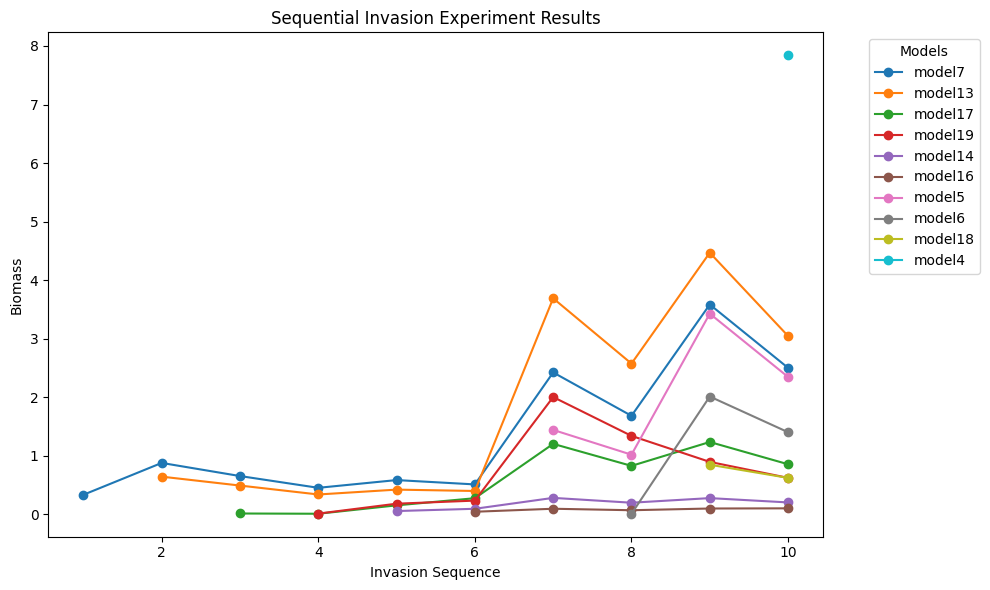

In [258]:
# Plotting
plt.figure(figsize=(10, 6))

for model in df.columns:
    plt.plot(df.index, df[model], marker='o', label=model)

plt.xlabel('Invasion Sequence')
plt.ylabel('Biomass')
plt.title('Sequential Invasion Experiment Results')
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

In [248]:
sp_id_list

[7, 13, 17, 19, 14, 16, 5, 6, 18, 4]